In [1]:
import warnings
warnings.filterwarnings('ignore')

### Find Cointegrated Pairs

In [2]:
import pandas as pd
from openbb import obb
obb.user.preferences.output_type = "dataframe"

Function for downloading historical data using openbb

In [3]:
from __future__ import annotations
import pandas as pd
import logging
from pandas.errors import EmptyDataError
from typing import Iterable, List, Tuple, Union, Optional

def download_history_openbb(
    tickers: Union[Iterable[str], pd.Series, pd.Index],
    start_date: Union[str, pd.Timestamp],
    end_date:   Union[str, pd.Timestamp],
    *,
    provider: str = "yfinance",
    show_progress: bool = True,
    silence_logs: bool = True,
    return_failed: bool = False,
):
    """
    Download historical OHLCV for multiple tickers via OpenBB and stitch into one DataFrame.

    Returns:
        df                      (pd.DataFrame): concatenated results with MultiIndex (ticker, datetime).
        (optionally) failed     (List[str])   : tickers that returned no data or errored.
    """
    from tqdm import tqdm
    try:
        from openbb import obb  # OpenBB v4
    except Exception as e:
        raise ImportError("OpenBB not available. `pip install openbb` (v4).") from e

    # Silence noisy logs if requested
    if silence_logs:
        for lg in ["openbb_core", "openbb_yfinance", "openbb", "yfinance"]:
            logging.getLogger(lg).setLevel(logging.CRITICAL)

    # Clean ticker list
    tickers = (
        pd.Index(pd.Series(list(tickers), dtype="object"))
        .dropna()
        .astype(str)
        .unique()
        .tolist()
    )

    frames: List[Tuple[str, pd.DataFrame]] = []
    failed: List[str] = []

    iterator = tqdm(tickers, desc="Download", disable=not show_progress)
    for tkr in iterator:
        if show_progress:
            iterator.set_description(tkr)
        try:
            df_new = obb.equity.price.historical(
                symbol=tkr,
                start_date=start_date,
                end_date=end_date,
                provider=provider,
            )
            if df_new is None or len(df_new) == 0:
                failed.append(tkr)
                continue

            # Ensure datetime-like index and name it consistently
            df_new = df_new.copy()
            if not isinstance(df_new.index, pd.DatetimeIndex):
                df_new.index = pd.to_datetime(df_new.index, errors="coerce")
            # Some providers name it 'date' — normalize to 'datetime'
            dt_name = df_new.index.name or "datetime"
            df_new.index = df_new.index.rename("datetime")

            frames.append((tkr, df_new))
        except (EmptyDataError, Exception):
            failed.append(tkr)

    if frames:
        # Concatenate using keys to form MultiIndex with ticker first, datetime second
        keys = [k for k, _ in frames]
        objs = [df for _, df in frames]
        df = pd.concat(objs, keys=keys, names=["ticker", "datetime"])
        # (Optional) sort by ticker then time
        df = df.sort_index(level=["ticker", "datetime"])
    else:
        # Return an empty frame with the correct MultiIndex shape and common OHLCV columns
        empty_index = pd.MultiIndex.from_arrays([[], []], names=["ticker", "datetime"])
        df = pd.DataFrame(index=empty_index, columns=["open", "high", "low", "close", "adj_close", "volume"])

    if return_failed:
        return df, failed
    return df


Function for importing historical data from parquet lakes

In [4]:
from __future__ import annotations
from pathlib import Path
from typing import Iterable, List, Optional, Literal
import os
os.environ["PYARROW_NUM_THREADS"] = "1"  # or 2–4

import pandas as pd
import datetime as dt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

def _month_range(start: dt.date, end: dt.date) -> List[tuple[int,int]]:
    y, m = start.year, start.month
    out = []
    while (y < end.year) or (y == end.year and m <= end.month):
        out.append((y, m))
        if m == 12: y, m = y + 1, 1
        else: m += 1
    return out

def _read_parquet(path: Path, columns: Optional[List[str]]) -> pd.DataFrame:
    return pd.read_parquet(path, columns=columns)

def load_polygonio_lake(
    tickers: Iterable[str],
    start_date: str | dt.date | dt.datetime,
    end_date: str | dt.date | dt.datetime,
    root: str | Path,
    *,
    columns: Optional[List[str]] = None,
    source_tz: str = "US/Eastern",
    to_timezone: Optional[str] = None,
    set_index: bool = False,
    index_multi: bool = False,
    debug: bool = False,
    # NEW (optional) knobs for parallel I/O:
    workers: Optional[int] = None,
    parallel_backend: Literal["thread","process"] = "thread"
) -> pd.DataFrame:
    """
    Load <root>/<ticker>/<YYYY>/<MM>.parquet into one DataFrame filtered to [start_date, end_date].
    - Shows a progress bar if debug=False.
    - Reads parquet files in parallel (thread pool by default). Use `parallel_backend="process"`
      if CPU (decompression) dominates; keep "thread" if I/O dominates.
    - Set `workers` to control concurrency (default: sensible value based on CPU count).
    """
    # --- parse bounds ---
    s = pd.to_datetime(start_date)
    e = pd.to_datetime(end_date)
    if isinstance(start_date, (dt.date, str)) and not isinstance(start_date, dt.datetime):
        s = s.normalize()
    if isinstance(end_date, (dt.date, str)) and not isinstance(end_date, dt.datetime):
        e = (e.normalize() + pd.Timedelta(days=1)) - pd.Timedelta(nanoseconds=1)

    # --- columns: force include datetime & ticker ---
    read_cols = None
    if columns is not None:
        need = {"datetime", "ticker"}
        read_cols = list(dict.fromkeys(list(columns) + list(need)))

    # --- enumerate files ---
    root = Path(root)
    months = _month_range(s.date(), e.date())
    files: List[Path] = []
    for t in tickers:
        for (yy, mm) in months:
            f = root / t / f"{yy:04d}" / f"{mm:02d}.parquet"
            if f.exists():
                files.append(f)

    if not files:
        if debug:
            print(f"[DEBUG] No files found for {tickers} in {s.date()}..{e.date()}")
        return pd.DataFrame(columns=read_cols or ["datetime","ticker"])

    # --- read files (parallel with progress bar unless debug=True) ---
    dfs: List[pd.DataFrame] = []

    if debug:
        # Sequential, verbose
        for f in files:
            try:
                df_part = _read_parquet(f, read_cols)
            except Exception as ex:
                print(f"[DEBUG] Failed to read {f}: {ex}")
                continue
            dfs.append(df_part)
    else:
        # Parallel + tqdm
        max_workers = workers or max(4, min(32, (os.cpu_count() or 8)))
        Exec = ThreadPoolExecutor if parallel_backend == "thread" else ProcessPoolExecutor
        with Exec(max_workers=max_workers) as ex, \
             tqdm(total=len(files), desc="Loading Parquet", unit="file") as pbar:
            futures = {ex.submit(_read_parquet, f, read_cols): f for f in files}
            for fut in as_completed(futures):
                f = futures[fut]
                try:
                    dfs.append(fut.result())
                except Exception as exn:
                    # Keep going; show which file failed
                    pbar.write(f"[WARN] Failed to read {f}: {exn}")
                finally:
                    pbar.update(1)

    if not dfs:
        # Everything failed (or empty files)
        return pd.DataFrame(columns=read_cols or ["datetime","ticker"])

    df = pd.concat(dfs, ignore_index=True)

    # --- timezone handling (modern dtype check) ---
    if "datetime" not in df.columns:
        raise KeyError("Expected 'datetime' column in parquet files.")

    dtype = df["datetime"].dtype
    if not isinstance(dtype, pd.DatetimeTZDtype):
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
        df["datetime"] = df["datetime"].dt.tz_localize(
            source_tz, nonexistent="shift_forward", ambiguous="NaT"
        )
    if to_timezone:
        df["datetime"] = df["datetime"].dt.tz_convert(to_timezone)

    # --- filter by date ---
    tz = df["datetime"].dt.tz
    s_bound = s if s.tzinfo else s.tz_localize(tz)
    e_bound = e if e.tzinfo else e.tz_localize(tz)
    df = df[(df["datetime"] >= s_bound) & (df["datetime"] <= e_bound)]

    # --- filter tickers ---
    if "ticker" in df.columns:
        df = df[df["ticker"].isin(set(tickers))]

    # --- sort + index ---
    sort_cols = ["ticker","datetime"] if "ticker" in df.columns else ["datetime"]
    df = df.sort_values(sort_cols)
    if set_index:
        if index_multi and "ticker" in df.columns:
            df = df.set_index(["ticker","datetime"]).sort_index()
        else:
            df = df.set_index("datetime").sort_index()

    return df


In [5]:
# tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

import json

# 1. Open the file
with open("ticker_lists/ndx.json", "r", encoding="utf-8") as f:
    # 2. Parse the JSON
    tickers = json.load(f)      # <-- data is now a Python object
tickers.sort()

In [6]:


"""
start_date="2015-01-01"
end_date="2025-01-01"

df, failed = download_history_openbb(tickers, start_date, end_date, return_failed=True)

print(df.head())
if failed:
    print("No data for:", failed)
"""

'\nstart_date="2015-01-01"\nend_date="2025-01-01"\n\ndf, failed = download_history_openbb(tickers, start_date, end_date, return_failed=True)\n\nprint(df.head())\nif failed:\n    print("No data for:", failed)\n'

In [ ]:
start_date = "2015-01-01"
end_date   = "2025-01-01"
path_polygonio_data = "/home/mengren/data/polygonio_data/parquet_lake/day_aggs_v1/spx_ndx_adjusted"

df = load_polygonio_lake(
    tickers,
    start_date,
    end_date,
    path_polygonio_data,
    columns=["datetime","ticker","open","high","low","close","volume"],
    to_timezone="UTC",
    set_index=True, index_multi=True,
    workers=64,
    debug=False
)
print(df.shape)

Loading Parquet: 100%|██████████| 10919/10919 [00:21<00:00, 513.06file/s]


(226505, 5)


In [8]:
df

open        high         low  \
ticker datetime                                                        
AAPL   2015-01-02 05:00:00+00:00  111.389999  111.440002  107.349998   
       2015-01-05 05:00:00+00:00  108.290001  108.650002  105.410004   
       2015-01-06 05:00:00+00:00  106.540001  107.430000  104.629997   
       2015-01-07 05:00:00+00:00  107.199997  108.199997  106.695000   
       2015-01-08 05:00:00+00:00  109.230003  112.150002  108.699997   
...                                      ...         ...         ...   
ZS     2024-12-24 05:00:00+00:00  185.979996  187.589996  184.679993   
       2024-12-26 05:00:00+00:00  186.000000  188.499893  185.869995   
       2024-12-27 05:00:00+00:00  185.259995  185.929993  181.259995   
       2024-12-30 05:00:00+00:00  181.529999  184.404999  180.100006   
       2024-12-31 05:00:00+00:00  184.115005  184.199997  179.722794   

                                       close    volume  
ticker datetime                                         
AAPL   2015-01-02 05:00:00+00:00  109.330002  53181903  
       2015-01-05 05:00:00+00:00  106.250000  61888655  
       2015-01-06 05:00:00+00:00  106.260002  65769076  
       2015-01-07 05:00:00+00:00  107.750000  39958648  
       2015-01-08 05:00:00+00:00  111.889999  59364387  
...                                      ...       ...  
ZS     2024-12-24 05:00:00+00:00  187.259995    654154  
       2024-12-26 05:00:00+00:00  187.630005    806804  
       2024-12-27 05:00:00+00:00  184.559998   1256388  
       2024-12-30 05:00:00+00:00  183.130005   1032433  
       2024-12-31 05:00:00+00:00  180.410004    920751  

[226505 rows x 5 columns]

In [9]:
df.index.names

FrozenList(['ticker', 'datetime'])

In [10]:
df.index.get_level_values('datetime').min(), df.index.get_level_values('datetime').max()

(Timestamp('2015-01-02 05:00:00+0000', tz='UTC'),
 Timestamp('2024-12-31 05:00:00+0000', tz='UTC'))

### Pre-filter for Liquidity & Data Quality

In [11]:
import pandas as pd

# infer level names/positions
lvl_names = list(df.index.names)
ticker_lvl = 0                                  # you said ticker is first level
time_lvl_name = 'datetime' if 'datetime' in lvl_names else lvl_names[1]

# global time span
full_start = df.index.get_level_values(time_lvl_name).min()
full_end   = df.index.get_level_values(time_lvl_name).max()

# per-ticker start/end
starts = df.groupby(level=ticker_lvl).apply(
    lambda g: g.index.get_level_values(time_lvl_name).min()
)
ends = df.groupby(level=ticker_lvl).apply(
    lambda g: g.index.get_level_values(time_lvl_name).max()
)

# tickers whose coverage matches the global coverage
tickers_to_keep = starts[(starts == full_start) & (ends == full_end)].index

# filter df by those tickers
df_filtered = df.loc[pd.IndexSlice[tickers_to_keep, :]]


In [12]:
len(df.index.get_level_values('ticker').unique()), len(df_filtered.index.get_level_values('ticker').unique())

(101, 76)

In [13]:
set(tickers) - set(df_filtered.index.get_level_values('ticker').unique())

{'ABNB',
 'ARM',
 'AXON',
 'BKNG',
 'BKR',
 'CCEP',
 'CEG',
 'CRWD',
 'DASH',
 'DDOG',
 'GEHC',
 'GFS',
 'KDP',
 'KHC',
 'LIN',
 'META',
 'ON',
 'PDD',
 'PLTR',
 'PYPL',
 'SHOP',
 'TEAM',
 'TTD',
 'WBD',
 'ZS'}

In [14]:
df = df_filtered

### Initial Cointegration Screening
 - Engle-Granger test, or
 - Johansen test

In [15]:
# ===================== FAST COINTEGRATION SCAN (Executor + initializer, no lambdas) =====================
from typing import Literal, Optional, Tuple, List
from concurrent.futures import ProcessPoolExecutor
from itertools import combinations
from functools import partial
import os, numpy as np, pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from threadpoolctl import threadpool_limits
from tqdm import tqdm

# ---- worker globals (populated by _init_worker) ----
_SERIES_MAP = None
_KEYS = None
_FULL_START = None
_FULL_END = None

def _init_worker(series_map, keys, full_start, full_end):
    """Runs once per worker process. Store heavy objects in globals and cap BLAS threads."""
    global _SERIES_MAP, _KEYS, _FULL_START, _FULL_END
    _SERIES_MAP = series_map
    _KEYS = keys
    _FULL_START = full_start
    _FULL_END = full_end

    # Cap BLAS threads inside each process
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"

    # Best-effort: expand CPU affinity to all CPUs (harmless if already full)
    try:
        import psutil
        p = psutil.Process()
        if hasattr(p, "cpu_affinity"):
            p.cpu_affinity(list(range(os.cpu_count() or 1)))
    except Exception:
        pass

def _align_dropna(S1: pd.Series, S2: pd.Series) -> pd.DataFrame:
    return pd.concat([S1, S2], axis=1, keys=["S1", "S2"]).dropna()

def _alpha_to_col(alpha: float) -> int:
    if alpha <= 0.01: return 2
    if alpha <= 0.05: return 1
    if alpha <= 0.10: return 0
    return 1

def _task_eg(idx_pair, *, alpha: float, trend: str, maxlag: Optional[int], autolag: str):
    i, j = idx_pair
    k1, k2 = _KEYS[i], _KEYS[j]
    S1, S2 = _SERIES_MAP[k1], _SERIES_MAP[k2]

    # Require full-span coverage to avoid biased tests
    if not (S1.index[0] == _FULL_START and S1.index[-1] == _FULL_END and
            S2.index[0] == _FULL_START and S2.index[-1] == _FULL_END):
        return i, j, 0.0, np.nan, False

    df = _align_dropna(S1, S2)
    if len(df) < 50:
        return i, j, 0.0, np.nan, False

    with threadpool_limits(limits=1):
        tstat, pval, _ = coint(df["S1"], df["S2"], trend=trend, maxlag=maxlag, autolag=autolag)
    return i, j, float(tstat), float(pval), bool(pval < alpha)

def _task_johansen(idx_pair, *, alpha: float, det_order: int, k_ar_diff: int, stat: Literal["trace","maxeig"]):
    i, j = idx_pair
    k1, k2 = _KEYS[i], _KEYS[j]
    S1, S2 = _SERIES_MAP[k1], _SERIES_MAP[k2]

    if not (S1.index[0] == _FULL_START and S1.index[-1] == _FULL_END and
            S2.index[0] == _FULL_START and S2.index[-1] == _FULL_END):
        return i, j, 0.0, np.nan, False

    df = _align_dropna(S1, S2)
    if len(df) < 50:
        return i, j, 0.0, np.nan, False

    X = df[["S1", "S2"]].values
    with threadpool_limits(limits=1):
        res = coint_johansen(X, det_order=det_order, k_ar_diff=k_ar_diff)

    alpha_col = _alpha_to_col(alpha)
    if stat == "trace":
        test_stat, crit_val = float(res.lr1[0]), float(res.cvt[0, alpha_col])
    else:
        test_stat, crit_val = float(res.lr2[0]), float(res.cvm[0, alpha_col])
    return i, j, test_stat, np.nan, bool(test_stat > crit_val)

def find_cointegrated_pairs_executor(
    data: pd.DataFrame,
    *,
    alpha: float = 0.05,
    method: Literal["eg", "johansen"] = "eg",
    # EG
    eg_trend: str = "c",
    eg_maxlag: Optional[int] = None,
    eg_autolag: str = "aic",
    # Johansen
    joh_det_order: int = 0,
    joh_k_ar_diff: int = 1,
    joh_stat: Literal["trace", "maxeig"] = "trace",
    # parallel
    n_workers: Optional[int] = None,      # use physical cores on TR: 64
    chunksize: int = 4,                   # small chunks to keep all workers busy
    show_progress: bool = True,
) -> Tuple[np.ndarray, np.ndarray, List[tuple]]:
    """
    Expects `data` with a MultiIndex whose first level is ticker and second is datetime,
    and with a 'close' column.
    Returns:
        score_matrix (n x n)
        pvalue_matrix (n x n)  [np.nan for Johansen]
        pairs (List[Tuple[str, str]])  # native Python strings
    """
    # ---- Validate and normalize index ----
    if "close" not in data.columns:
        raise ValueError("data must have column 'close' and a MultiIndex (ticker, datetime).")
    if not isinstance(data.index, pd.MultiIndex) or data.index.nlevels < 2:
        raise ValueError("data must have a MultiIndex with (ticker, datetime) levels.")

    # Ensure level names = ("ticker", "datetime")
    names = list(data.index.names)
    if names[0] != "ticker" or names[1] != "datetime":
        new_names = names[:]
        new_names[0] = "ticker"
        new_names[1] = "datetime"
        data = data.copy()
        data.index = data.index.set_names(new_names)

    # Sort to guarantee monotonicity per series
    data = data.sort_index(level=["ticker", "datetime"])

    # ---- Build per-ticker close series with DatetimeIndex ----
    series_map = {}
    for k, g in data.groupby(level="ticker"):
        s = g["close"].copy()
        s.index = s.index.droplevel("ticker")          # leave only datetime in index
        if not isinstance(s.index, pd.DatetimeIndex):  # ensure dtype
            s.index = pd.to_datetime(s.index, errors="coerce")
        s = s.sort_index()
        series_map[str(k)] = s                         # ensure keys are native str

    # Native Python str keys (avoid np.str_)
    keys: List[str] = [str(k) for k in series_map.keys()]
    n = len(keys)

    score_matrix  = np.zeros((n, n))
    pvalue_matrix = np.full((n, n), np.nan)
    pairs: List[Tuple[str, str]] = []

    # Global span from the datetime level
    dt_index = data.index.get_level_values("datetime")
    full_start, full_end = dt_index.min(), dt_index.max()

    combos = list(combinations(range(n), 2))

    if n_workers is None:
        n_workers = max(1, (os.cpu_count() or 1) // 2)  # ~physical cores

    # Choose picklable task (partials are picklable; functions are top-level)
    if method == "eg":
        task = partial(_task_eg, alpha=alpha, trend=eg_trend, maxlag=eg_maxlag, autolag=eg_autolag)
        desc = "Engle–Granger cointegration tests"
    elif method == "johansen":
        task = partial(_task_johansen, alpha=alpha, det_order=joh_det_order,
                       k_ar_diff=joh_k_ar_diff, stat=joh_stat)
        desc = "Johansen cointegration tests"
    else:
        raise ValueError("method must be 'eg' or 'johansen'")

    # Run
    with ProcessPoolExecutor(
        max_workers=n_workers,
        initializer=_init_worker,
        initargs=(series_map, keys, full_start, full_end),
    ) as ex:
        it = ex.map(task, combos, chunksize=chunksize)
        if show_progress:
            it = tqdm(it, total=len(combos), desc=desc, leave=False)

        for i, j, score, pval, is_coint in it:
            k1, k2 = keys[i], keys[j]           # plain str
            score_matrix[i, j]  = score
            pvalue_matrix[i, j] = pval
            if is_coint:
                pairs.append((k1, k2))          # tuples of str

    return score_matrix, pvalue_matrix, pairs
# ===================== END FAST SCAN =====================


In [16]:
from typing import Literal, Optional, Tuple, List, Dict
import numpy as np
import pandas as pd

def find_cointegrated_pairs_dualgate(
    data: pd.DataFrame,
    *,
    # EG params
    alpha_eg: float = 0.05,
    eg_trend: str = "c",
    eg_maxlag: Optional[int] = None,
    eg_autolag: str = "aic",
    # Johansen params
    alpha_joh: float = 0.05,
    joh_det_order: int = 0,
    joh_k_ar_diff: int = 1,
    joh_stat: Literal["trace", "maxeig"] = "trace",
    # parallel
    n_workers: Optional[int] = None,
    chunksize: int = 4,
    show_progress: bool = True,
    # output options
    only_pass: bool = False,         # return only pairs that pass both tests
    sort_by: Optional[str] = "eg_p"  # e.g. "eg_p", "eg_t", "joh_stat" or None
) -> pd.DataFrame:
    """
    Run EG and Johansen, keep only pairs that pass BOTH (dual-gate), and
    return a stationarity-style summary DataFrame:

        index:  MultiIndex (ticker1, ticker2)
        cols :  ["eg_t", "eg_p", "eg_pass", "joh_stat", "joh_pass", "verdict"]

    Notes:
    - We expose Johansen's test statistic (joh_stat). Critical values aren’t returned by
      the underlying executor; pass/fail is computed there. If you want crit values too,
      we can extend the executor to emit them.
    """
    # ---- Run EG ----
    score_eg, pval_eg, pairs_eg = find_cointegrated_pairs_executor(
        data,
        alpha=alpha_eg,
        method="eg",
        eg_trend=eg_trend,
        eg_maxlag=eg_maxlag,
        eg_autolag=eg_autolag,
        n_workers=n_workers,
        chunksize=chunksize,
        show_progress=show_progress,
    )

    # ---- Run Johansen ----
    score_joh, pval_joh, pairs_joh = find_cointegrated_pairs_executor(
        data,
        alpha=alpha_joh,
        method="johansen",
        joh_det_order=joh_det_order,
        joh_k_ar_diff=joh_k_ar_diff,
        joh_stat=joh_stat,
        n_workers=n_workers,
        chunksize=chunksize,
        show_progress=show_progress,
    )

    # ticker order used for the matrices
    tickers: List[str] = [str(t) for t in data.index.get_level_values("ticker").unique().tolist()]
    n = len(tickers)

    # quick membership sets for pass/fail
    eg_set  = set(map(tuple, pairs_eg))
    joh_set = set(map(tuple, pairs_joh))

    # build rows from upper triangle
    rows = []
    for i in range(n):
        for j in range(i+1, n):
            k1, k2 = tickers[i], tickers[j]
            eg_t   = score_eg[i, j]
            eg_p   = pval_eg[i, j]
            joh_st = score_joh[i, j]  # pval_joh is nan by design

            eg_pass  = (k1, k2) in eg_set or (k2, k1) in eg_set
            joh_pass = (k1, k2) in joh_set or (k2, k1) in joh_set
            verdict  = "pass" if (eg_pass and joh_pass) else "fail"

            rows.append((k1, k2, eg_t, eg_p, eg_pass, joh_st, joh_pass, verdict))

    df_out = pd.DataFrame(
        rows,
        columns=["ticker1", "ticker2", "eg_t", "eg_p", "eg_pass", "joh_stat", "joh_pass", "verdict"],
    ).set_index(["ticker1", "ticker2"])

    if only_pass:
        df_out = df_out[df_out["verdict"] == "pass"]

    if sort_by is not None and sort_by in df_out.columns:
        if sort_by == "eg_p":
            df_out = df_out.sort_values(by=["verdict", sort_by], ascending=[False, True])
        elif sort_by in ("eg_t", "joh_stat"):
            df_out = df_out.sort_values(by=["verdict", sort_by], ascending=[False, False])
        else:
            df_out = df_out.sort_values(by=sort_by, ascending=True)

    return df_out


In [17]:
"""
# Put these caps at the VERY TOP of your main script (before numpy/pandas/statsmodels imports)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

# Threadripper 3990X: start with 64 workers, small chunks
score_m, pval_m, pairs_eg = find_cointegrated_pairs_executor(
    df,
    alpha=0.05,
    method="eg",
    n_workers=128,
    chunksize=4,     # try 1–8 depending on variance of task runtime
    show_progress=True,
)
"""

'\n# Put these caps at the VERY TOP of your main script (before numpy/pandas/statsmodels imports)\nimport os\nos.environ["OMP_NUM_THREADS"] = "1"\nos.environ["MKL_NUM_THREADS"] = "1"\nos.environ["OPENBLAS_NUM_THREADS"] = "1"\nos.environ["NUMEXPR_NUM_THREADS"] = "1"\nos.environ["VECLIB_MAXIMUM_THREADS"] = "1"\n\n# Threadripper 3990X: start with 64 workers, small chunks\nscore_m, pval_m, pairs_eg = find_cointegrated_pairs_executor(\n    df,\n    alpha=0.05,\n    method="eg",\n    n_workers=128,\n    chunksize=4,     # try 1–8 depending on variance of task runtime\n    show_progress=True,\n)\n'

In [18]:
"""
score_m_j, pval_m_j, pairs_joh = find_cointegrated_pairs_executor(
    df,
    alpha=0.05,
    method="johansen",
    joh_det_order=0,
    joh_k_ar_diff=1,
    joh_stat="trace",   # or "maxeig"
    n_workers=128,
    chunksize=4,
    show_progress=True,
)
"""

'\nscore_m_j, pval_m_j, pairs_joh = find_cointegrated_pairs_executor(\n    df,\n    alpha=0.05,\n    method="johansen",\n    joh_det_order=0,\n    joh_k_ar_diff=1,\n    joh_stat="trace",   # or "maxeig"\n    n_workers=128,\n    chunksize=4,\n    show_progress=True,\n)\n'

In [19]:
"""
res = find_cointegrated_pairs_dualgate(
    df,
    alpha_eg=0.05,
    eg_trend="c",
    eg_maxlag=None,
    eg_autolag="aic",
    alpha_joh=0.05,
    joh_det_order=0,
    joh_k_ar_diff=1,
    joh_stat="trace",
    n_workers=40,     # e.g., ~physical cores on 3990X
    chunksize=8,
    show_progress=True,
)

pairs_dual = res["pairs_dual"]
print(f"Dual-gate pairs: {len(pairs_dual)}")
"""

'\nres = find_cointegrated_pairs_dualgate(\n    df,\n    alpha_eg=0.05,\n    eg_trend="c",\n    eg_maxlag=None,\n    eg_autolag="aic",\n    alpha_joh=0.05,\n    joh_det_order=0,\n    joh_k_ar_diff=1,\n    joh_stat="trace",\n    n_workers=40,     # e.g., ~physical cores on 3990X\n    chunksize=8,\n    show_progress=True,\n)\n\npairs_dual = res["pairs_dual"]\nprint(f"Dual-gate pairs: {len(pairs_dual)}")\n'

In [20]:
summary_dual = find_cointegrated_pairs_dualgate(
    df,
    alpha_eg=0.05, eg_trend="c",
    alpha_joh=0.05, joh_det_order=0, joh_k_ar_diff=1, joh_stat="trace",
    n_workers=40, chunksize=8, show_progress=True
)

In [21]:
summary_dual

eg_t      eg_p  eg_pass   joh_stat  joh_pass verdict
ticker1 ticker2                                                          
AVGO    CTAS    -5.767036  0.000005     True  47.903395      True    pass
AMAT    NXPI    -5.677388  0.000008     True  34.441828      True    pass
AVGO    LRCX    -5.422464  0.000026     True  58.796851      True    pass
HON     TXN     -5.055197  0.000130     True  31.842184      True    pass
CTAS    LRCX    -4.982980  0.000177     True  58.209838      True    pass
...                   ...       ...      ...        ...       ...     ...
COST    MCHP     1.875138  1.000000    False  10.087039     False    fail
        PANW     0.945883  1.000000    False  10.613011     False    fail
        TSLA     1.493797  1.000000    False  16.747056      True    fail
KLAC    LRCX     1.628604  1.000000    False  15.615072      True    fail
ORLY    TSLA     0.963949  1.000000    False  14.734550     False    fail

[2850 rows x 6 columns]

In [22]:
# summary_dual is what find_cointegrated_pairs_dualgate returns
tmp = summary_dual.copy()
tmp["rank_eg"]  = tmp["eg_p"].rank(method="average", ascending=True)
tmp["rank_joh"] = tmp["joh_stat"].rank(method="average", ascending=False)
# normalize to [0,1] and average
tmp["pre_score"] = 0.5*(tmp["rank_eg"]/tmp["rank_eg"].max()
                      + tmp["rank_joh"]/tmp["rank_joh"].max())
prelim = tmp.sort_values("pre_score", ascending=True)   # lower rank is better
# pick top N (e.g., 2–3× the number you intend to trade)
candidates = prelim.head(50).index.to_list()

In [23]:
candidates

[('AVGO', 'CTAS'),
 ('AVGO', 'LRCX'),
 ('CTAS', 'LRCX'),
 ('MSTR', 'NVDA'),
 ('AMAT', 'NXPI'),
 ('HON', 'TXN'),
 ('FTNT', 'TSLA'),
 ('AMZN', 'GOOG'),
 ('AMZN', 'GOOGL'),
 ('ASML', 'NXPI'),
 ('AMGN', 'PCAR'),
 ('CTAS', 'MDLZ'),
 ('GOOG', 'TSLA'),
 ('DXCM', 'TSLA'),
 ('AMGN', 'TMUS'),
 ('GOOGL', 'TSLA'),
 ('AVGO', 'ODFL'),
 ('MU', 'PCAR'),
 ('PCAR', 'QCOM'),
 ('AMD', 'PCAR'),
 ('NXPI', 'PCAR'),
 ('PCAR', 'TMUS'),
 ('CDW', 'CTAS'),
 ('NVDA', 'ODFL'),
 ('BIIB', 'COST'),
 ('LRCX', 'MSTR'),
 ('LRCX', 'NVDA'),
 ('NVDA', 'QCOM'),
 ('SNPS', 'TRI'),
 ('EXC', 'GILD'),
 ('AMGN', 'VRTX'),
 ('MELI', 'PCAR'),
 ('CDW', 'MDLZ'),
 ('FTNT', 'PANW'),
 ('AAPL', 'CMCSA'),
 ('NVDA', 'NXPI'),
 ('AMGN', 'CTAS'),
 ('ADBE', 'WDAY'),
 ('AVGO', 'REGN'),
 ('BIIB', 'PCAR'),
 ('BIIB', 'MRVL'),
 ('MCHP', 'NVDA'),
 ('PCAR', 'VRSK'),
 ('CDNS', 'TRI'),
 ('AVGO', 'MDLZ'),
 ('MSTR', 'NXPI'),
 ('AMAT', 'PCAR'),
 ('ADI', 'PCAR'),
 ('BIIB', 'MSFT'),
 ('BIIB', 'MAR')]

In [24]:
pairs_dual = summary_dual[summary_dual["verdict"] == "pass"].index.to_list()

In [25]:
len(pairs_dual)

219

In [26]:
from pprint import pprint
pprint(pairs_dual)

[('AVGO', 'CTAS'),
 ('AMAT', 'NXPI'),
 ('AVGO', 'LRCX'),
 ('HON', 'TXN'),
 ('CTAS', 'LRCX'),
 ('PCAR', 'TMUS'),
 ('AMGN', 'PCAR'),
 ('MSTR', 'NVDA'),
 ('ASML', 'NXPI'),
 ('MU', 'PCAR'),
 ('FTNT', 'TSLA'),
 ('PCAR', 'QCOM'),
 ('MSTR', 'NXPI'),
 ('NXPI', 'PCAR'),
 ('CTAS', 'MDLZ'),
 ('AMGN', 'SNPS'),
 ('AMD', 'PCAR'),
 ('AMGN', 'ROP'),
 ('AMGN', 'MSFT'),
 ('CDW', 'MDLZ'),
 ('MSTR', 'REGN'),
 ('AMZN', 'GOOG'),
 ('AMGN', 'VRSK'),
 ('AMZN', 'GOOGL'),
 ('AVGO', 'ODFL'),
 ('MELI', 'PCAR'),
 ('CDW', 'CTAS'),
 ('PCAR', 'VRSK'),
 ('AMGN', 'MU'),
 ('AMGN', 'TMUS'),
 ('AMGN', 'VRTX'),
 ('MSTR', 'QCOM'),
 ('AMAT', 'PCAR'),
 ('PCAR', 'TRI'),
 ('ADSK', 'TTWO'),
 ('SNPS', 'TRI'),
 ('AMGN', 'CDW'),
 ('GOOG', 'TSLA'),
 ('ADI', 'PCAR'),
 ('CDNS', 'TRI'),
 ('INTU', 'PCAR'),
 ('GOOGL', 'TSLA'),
 ('AMD', 'AMGN'),
 ('PCAR', 'TXN'),
 ('INTU', 'MSFT'),
 ('AAPL', 'CMCSA'),
 ('MSFT', 'PCAR'),
 ('LRCX', 'MSTR'),
 ('NVDA', 'ODFL'),
 ('BIIB', 'COST'),
 ('DXCM', 'TSLA'),
 ('ADI', 'AMGN'),
 ('AVGO', 'MDLZ'),
 ('EA', 

### Apply Kalman Filter to Estimate $\alpha_t$ (intercept) and $\beta_t$ (Dynamic Hedge Ratio) and test $\varepsilon_t$ (spread) for stationarity

In [27]:
from itertools import combinations
from typing import Optional, Literal, Dict, Tuple, List
import os, numpy as np, pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import joblib
from contextlib import contextmanager

# pykalman
from pykalman import KalmanFilter

# ---------- progress helper for joblib + tqdm ----------
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

# ---------- helpers ----------
def _align_pair_multiindex(data: pd.DataFrame, k1: str, k2: str) -> pd.DataFrame:
    """
    Align two close-price series from a MultiIndex (ticker, datetime) DataFrame.
    Returns a float64 DataFrame with columns ['P1','P2'] on the datetime index.
    """
    # Expect: first level 'ticker', second level 'datetime'
    if not isinstance(data.index, pd.MultiIndex) or data.index.nlevels < 2:
        raise ValueError("data must have a MultiIndex with (ticker, datetime).")
    if "close" not in data.columns:
        raise ValueError("data must include a 'close' column.")

    # Slice by ticker level, drop ticker level to leave only datetime, then align
    s1 = data.loc[(k1,), "close"]
    s2 = data.loc[(k2,), "close"]
    if isinstance(s1.index, pd.MultiIndex):
        s1 = s1.droplevel(0)
    if isinstance(s2.index, pd.MultiIndex):
        s2 = s2.droplevel(0)

    # Ensure datetime index and sort
    if not isinstance(s1.index, pd.DatetimeIndex):
        s1.index = pd.to_datetime(s1.index, errors="coerce")
    if not isinstance(s2.index, pd.DatetimeIndex):
        s2.index = pd.to_datetime(s2.index, errors="coerce")
    s1 = s1.sort_index()
    s2 = s2.sort_index()

    df = pd.concat([s1.rename("P1"), s2.rename("P2")], axis=1).dropna()
    return df.astype(np.float64)

def _kalman_dynamic_hedge(
    k1: str,
    k2: str,
    df: pd.DataFrame,
    *,
    q: float = 1e-5,
    r: float = 1.0,
    init_cov: float = 1e6,
    mode: Literal["smooth", "filter"] = "smooth",
    em_iters: int = 0,
    return_params: bool = False,
):
    if df is None or len(df) < 5:
        return k1, k2, None, None

    y = df["P1"].values.reshape(-1, 1)
    x = df["P2"].values
    n = len(df)

    # H_t = [[x_t, 1]]
    H = np.zeros((n, 1, 2), dtype=np.float64)
    H[:, 0, 0] = x
    H[:, 0, 1] = 1.0
    F = np.eye(2, dtype=np.float64)

    kf = KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        initial_state_mean=np.array([0.0, 0.0], dtype=np.float64),   # [beta0, alpha0]
        initial_state_covariance=np.eye(2, dtype=np.float64) * init_cov,
        transition_covariance=np.eye(2, dtype=np.float64) * q,
        observation_covariance=np.array([[r]], dtype=np.float64),
    )

    if em_iters and em_iters > 0:
        kf = kf.em(y, n_iter=em_iters)  # learns Q,R (and possibly init covs)

    if mode == "smooth":
        state_means, state_covs = kf.smooth(y)
        if return_params:
            f_means, f_covs = kf.filter(y)
            last_mean, last_cov = f_means[-1].copy(), f_covs[-1].copy()
    else:
        state_means, state_covs = kf.filter(y)
        last_mean, last_cov = state_means[-1].copy(), state_covs[-1].copy()

    beta_t  = state_means[:, 0]
    alpha_t = state_means[:, 1]
    y_hat   = alpha_t + beta_t * x
    resid   = df["P1"].values - y_hat

    states_df = pd.DataFrame(
        {"alpha": alpha_t, "beta": beta_t, "y_hat": y_hat, "resid": resid},
        index=df.index,  # datetime index
    )

    params = None
    if return_params:
        params = {
            "F": F.copy(),
            "Q": kf.transition_covariance.copy(),
            "R": kf.observation_covariance.copy(),
            "last_state_mean": last_mean,
            "last_state_cov": last_cov,
            "mode": mode,
            "em_iters": int(em_iters),
        }

    return k1, k2, states_df, params

# ---------- main API ----------
def kalman_dynamic_hedge_joblib(
    data: pd.DataFrame,
    pairs: Optional[List[Tuple[str, str]]] = None,
    *,
    q: float = 1e-5,
    r: float = 1.0,
    init_cov: float = 1e6,
    mode: Literal["smooth", "filter"] = "smooth",
    em_iters: int = 0,
    require_full_span: bool = False,
    n_workers: Optional[int] = None,
    chunksize: int = 100,
    show_progress: bool = True,
    return_params: bool = False,
):
    """
    Expects `data` with MultiIndex (ticker, datetime) and a 'close' column.

    Returns:
      - if return_params=False: dict[(k1,k2)] -> states DataFrame (index=datetime)
      - if return_params=True : (states_dict, params_dict)
    """
    # Avoid BLAS oversubscription
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS",      "1")
    os.environ.setdefault("NUMEXPR_NUM_THREADS",  "1")

    if "close" not in data.columns:
        raise ValueError("data must include a 'close' column.")
    if not isinstance(data.index, pd.MultiIndex) or data.index.nlevels < 2:
        raise ValueError("data must have a MultiIndex with levels (ticker, datetime).")

    # Normalize level names and sort
    names = list(data.index.names)
    if names[0] != "ticker" or names[1] != "datetime":
        new_names = names[:]
        new_names[0] = "ticker"
        new_names[1] = "datetime"
        data = data.copy()
        data.index = data.index.set_names(new_names)
    data = data.sort_index(level=["ticker", "datetime"])

    # Native Python strings for tickers
    tickers: List[str] = [str(k) for k in data.index.get_level_values("ticker").unique().tolist()]

    # Build the list of pairs to evaluate
    if pairs is None:
        idx_pairs: List[Tuple[str, str]] = list(combinations(tickers, 2))
    else:
        # ensure native str
        idx_pairs = [(str(a), str(b)) for (a, b) in pairs]

    # Optionally require full-span coverage on the datetime level
    if require_full_span:
        dt = data.index.get_level_values("datetime")
        full_start, full_end = dt.min(), dt.max()

        def _full_span_ok(k: str) -> bool:
            s = data.loc[(k,), "close"]
            if isinstance(s.index, pd.MultiIndex):
                s = s.droplevel(0)
            return (len(s) > 0) and (s.index.min() == full_start) and (s.index.max() == full_end)

        idx_pairs = [(a, b) for (a, b) in idx_pairs if _full_span_ok(a) and _full_span_ok(b)]

    n_workers = n_workers or os.cpu_count() or 1

    def worker(k1: str, k2: str):
        df_ab = _align_pair_multiindex(data, k1, k2)
        return _kalman_dynamic_hedge(
            k1, k2, df_ab,
            q=q, r=r, init_cov=init_cov,
            mode=mode, em_iters=em_iters,
            return_params=return_params,
        )

    iterator = (delayed(worker)(k1, k2) for (k1, k2) in idx_pairs)

    if show_progress:
        with tqdm_joblib(tqdm(total=len(idx_pairs), desc="Kalman (α_t, β_t)", leave=False)):
            results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)
    else:
        results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)

    states_out: Dict[Tuple[str, str], pd.DataFrame] = {}
    params_out: Dict[Tuple[str, str], dict] = {}

    for k1, k2, df_res, params in results:
        if df_res is not None:
            states_out[(k1, k2)] = df_res
            if return_params and params is not None:
                params_out[(k1, k2)] = params

    if return_params:
        return states_out, params_out
    return states_out


In [28]:
# TRAIN
states_tr, params_tr = kalman_dynamic_hedge_joblib(
    df, pairs=pairs_dual,
    q=1e-5, r=1.0, mode="filter", em_iters=10,
    return_params=True
)

In [29]:
states_tr.keys(), params_tr.keys()

(dict_keys([('AVGO', 'CTAS'), ('AMAT', 'NXPI'), ('AVGO', 'LRCX'), ('HON', 'TXN'), ('CTAS', 'LRCX'), ('PCAR', 'TMUS'), ('AMGN', 'PCAR'), ('MSTR', 'NVDA'), ('ASML', 'NXPI'), ('MU', 'PCAR'), ('FTNT', 'TSLA'), ('PCAR', 'QCOM'), ('MSTR', 'NXPI'), ('NXPI', 'PCAR'), ('CTAS', 'MDLZ'), ('AMGN', 'SNPS'), ('AMD', 'PCAR'), ('AMGN', 'ROP'), ('AMGN', 'MSFT'), ('CDW', 'MDLZ'), ('MSTR', 'REGN'), ('AMZN', 'GOOG'), ('AMGN', 'VRSK'), ('AMZN', 'GOOGL'), ('AVGO', 'ODFL'), ('MELI', 'PCAR'), ('CDW', 'CTAS'), ('PCAR', 'VRSK'), ('AMGN', 'MU'), ('AMGN', 'TMUS'), ('AMGN', 'VRTX'), ('MSTR', 'QCOM'), ('AMAT', 'PCAR'), ('PCAR', 'TRI'), ('ADSK', 'TTWO'), ('SNPS', 'TRI'), ('AMGN', 'CDW'), ('GOOG', 'TSLA'), ('ADI', 'PCAR'), ('CDNS', 'TRI'), ('INTU', 'PCAR'), ('GOOGL', 'TSLA'), ('AMD', 'AMGN'), ('PCAR', 'TXN'), ('INTU', 'MSFT'), ('AAPL', 'CMCSA'), ('MSFT', 'PCAR'), ('LRCX', 'MSTR'), ('NVDA', 'ODFL'), ('BIIB', 'COST'), ('DXCM', 'TSLA'), ('ADI', 'AMGN'), ('AVGO', 'MDLZ'), ('EA', 'MU'), ('PCAR', 'ROP'), ('EXC', 'GILD'), (

In [30]:
from typing import Dict, Tuple, Optional
import os, numpy as np, pandas as pd, warnings
from joblib import Parallel, delayed
from tqdm import tqdm
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.stattools import adfuller, kpss

# ----------------- Half-life estimation -----------------
def estimate_halflife(resid: pd.Series) -> float:
    """Estimate half-life of mean reversion from residual series."""
    r = pd.Series(resid).dropna().astype(float)
    if len(r) < 20:
        return np.nan
    r_lag = r.shift(1).dropna()
    y = r.loc[r_lag.index]
    x = r_lag
    # OLS y = a + b x
    X = np.column_stack([np.ones(len(x)), x.values])
    beta = np.linalg.lstsq(X, y.values, rcond=None)[0]
    b = float(beta[1])
    if b <= 0 or b >= 1 or not np.isfinite(b):
        return np.nan
    return -np.log(2.0) / np.log(b)

# ----------------- Stationarity tests -------------------
def test_spread_stationarity(spread: pd.Series, alpha: float = 0.05, regression: str = "c") -> dict:
    s = pd.Series(spread).astype(float).dropna()
    adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, *_ = adfuller(s, autolag="AIC", regression=regression)
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(
        s, regression="c" if regression == "c" else "ct", nlags="auto"
    )
    adf_reject  = adf_p < alpha
    kpss_reject = kpss_p < alpha
    if adf_reject and not kpss_reject:
        verdict = "stationary"
    elif (not adf_reject) and kpss_reject:
        verdict = "non-stationary"
    else:
        verdict = "inconclusive"
    return {
        "adf_stat": adf_stat, "adf_p": adf_p,
        "adf_lags": adf_lags, "adf_nobs": adf_nobs, "adf_crit": adf_crit,
        "kpss_stat": kpss_stat, "kpss_p": kpss_p,
        "kpss_lags": kpss_lags, "kpss_crit": kpss_crit,
        "verdict": verdict
    }

# assumes tqdm_joblib(...) already exists
def _pair_stationarity_worker(
    k1: str, k2: str, resid_values: np.ndarray,
    alpha: float, regression: str, suppress_warnings: bool = True
) -> Optional[dict]:
    s = pd.Series(resid_values)
    if s.dropna().empty:
        return None
    if suppress_warnings:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", InterpolationWarning)
            warnings.simplefilter("ignore", UserWarning)
            warnings.simplefilter("ignore", RuntimeWarning)
            res = test_spread_stationarity(s, alpha=alpha, regression=regression)
    else:
        res = test_spread_stationarity(s, alpha=alpha, regression=regression)
    hl = estimate_halflife(s)
    return {
        "ticker1": k1, "ticker2": k2,
        "adf_stat": res["adf_stat"], "adf_p": res["adf_p"],
        "kpss_stat": res["kpss_stat"], "kpss_p": res["kpss_p"],
        "verdict": res["verdict"],
        "halflife": hl,
    }

# ----------------- Main API -----------------------------
def summarize_spread_stationarity_joblib(
    kf_results: Dict[Tuple[str, str], pd.DataFrame],
    *,
    alpha: float = 0.05,
    regression: str = "c",
    n_workers: Optional[int] = None,
    chunksize: int = 256,
    show_progress: bool = True,
    suppress_warnings: bool = True,
) -> pd.DataFrame:
    """
    Parallel summary of ADF+KPSS stationarity tests for 'resid'
    plus half-life estimation and residual sigma.
    Verdict is last column.
    """
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS",      "1")
    os.environ.setdefault("NUMEXPR_NUM_THREADS",  "1")

    n_workers = n_workers or os.cpu_count()

    tasks = []
    for (k1, k2), df in kf_results.items():
        if "resid" not in df.columns:
            continue
        resid_values = df["resid"].to_numpy(dtype=float, copy=False)
        tasks.append((k1, k2, resid_values))

    def worker_with_sigma(k1, k2, resid_values):
        s = pd.Series(resid_values)
        if s.dropna().empty:
            return None
        if suppress_warnings:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", InterpolationWarning)
                warnings.simplefilter("ignore", UserWarning)
                warnings.simplefilter("ignore", RuntimeWarning)
                res = test_spread_stationarity(s, alpha=alpha, regression=regression)
        else:
            res = test_spread_stationarity(s, alpha=alpha, regression=regression)

        # Half-life estimation
        halflife = np.nan
        try:
            spread_lag = s.shift(1).dropna()
            spread_ret = s.diff().dropna()
            beta = np.polyfit(spread_lag, spread_ret, 1)[0]
            halflife = -np.log(2) / beta if beta != 0 else np.nan
        except Exception:
            pass

        resid_sigma = float(s.std())

        return {
            "ticker1": k1, "ticker2": k2,
            "adf_stat": res["adf_stat"], "adf_p": res["adf_p"],
            "kpss_stat": res["kpss_stat"], "kpss_p": res["kpss_p"],
            "halflife": halflife,
            "resid_sigma": resid_sigma,
            "verdict": res["verdict"],
        }

    iterator = (
        delayed(worker_with_sigma)(k1, k2, resid_values)
        for (k1, k2, resid_values) in tasks
    )

    if show_progress:
        with tqdm_joblib(tqdm(total=len(tasks), desc="Testing stationarity", leave=False)):
            results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)
    else:
        results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)

    rows = [r for r in results if r is not None]
    if not rows:
        return pd.DataFrame(
            columns=["adf_stat","adf_p","kpss_stat","kpss_p","halflife","resid_sigma","verdict"],
            index=pd.MultiIndex.from_tuples([], names=["ticker1","ticker2"])
        )

    out = pd.DataFrame(rows).set_index(["ticker1", "ticker2"])

    # Ensure column order: halflife and resid_sigma before verdict
    col_order = ["adf_stat", "adf_p", "kpss_stat", "kpss_p", "halflife", "resid_sigma", "verdict"]
    out = out[col_order]

    # Sort by verdict then adf_p
    out = out.sort_values(["verdict", "adf_p"])
    return out




In [31]:
summary_stationarity = summarize_spread_stationarity_joblib(states_tr, alpha=0.05, regression="c", 
                                                            chunksize=256, show_progress=True)


Testing stationarity:   0%|          | 0/219 [00:00<?, ?it/s]

In [32]:
summary_stationarity

,,adf_stat,adf_p,kpss_stat,kpss_p,halflife,resid_sigma,verdict
ticker1,ticker2,,,,,,,
LRCX,NVDA,-24.263148,0.000000e+00,0.653735,0.017751,1.318962,9.838020,inconclusive
AZN,ROP,-30.948940,0.000000e+00,0.513524,0.038621,1.256005,0.395256,inconclusive
CTAS,NVDA,-23.947729,0.000000e+00,0.624058,0.020449,1.436928,7.780675,inconclusive
AVGO,CTAS,-28.512191,0.000000e+00,0.194627,0.100000,0.779931,0.429841,stationary
PCAR,TMUS,-36.238650,0.000000e+00,0.111971,0.100000,1.026992,0.340422,stationary
...,...,...,...,...,...,...,...,...
HON,MELI,-9.285479,1.218757e-15,0.148460,0.100000,1.359465,0.605188,stationary
AZN,CTAS,-9.280364,1.255920e-15,0.314089,0.100000,1.654352,0.657462,stationary
EA,TTWO,-9.185174,2.197511e-15,0.246075,0.100000,1.357211,0.534907,stationary


In [33]:
import numpy as np
import pandas as pd

def Z(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    m = s.mean()
    sd = s.std(ddof=0)
    if not np.isfinite(sd) or sd == 0:
        return pd.Series(0.0, index=s.index)
    return (s - m) / sd


In [34]:
final_df = summary_stationarity.copy()

# safe Series fallback for sharpe_train
sharpe_series = final_df.get("sharpe_train", pd.Series(0.0, index=final_df.index))

final_df["score"] = (
      Z(-np.log10(final_df["adf_p"].clip(lower=1e-12)))   # smaller p → larger score
    + Z(final_df["kpss_p"])                                # larger p better
    + Z(-np.log1p(final_df["halflife"]))                   # shorter better
    + Z(-final_df["resid_sigma"])                          # lower noise better
    + Z(sharpe_series)                                     # optional Sharpe
)

# Optional OOS sanity filter if present
if {"adf_p_test","kpss_p_test"}.issubset(final_df.columns):
    good_oos = (final_df["adf_p_test"] < 0.05) & (final_df["kpss_p_test"] > 0.10)
    final_df = final_df[good_oos]

ranked = final_df.sort_values("score", ascending=False)

In [35]:
ranked

,,adf_stat,adf_p,kpss_stat,kpss_p,halflife,resid_sigma,verdict,score
ticker1,ticker2,,,,,,,,
GOOG,GOOGL,-13.301238,7.040860e-25,0.037626,0.100000,0.668590,0.061861,stationary,2.245587
CDNS,ORLY,-12.545698,2.263029e-23,0.163177,0.100000,0.719752,0.106530,stationary,1.978534
AMD,ROP,-47.951338,0.000000e+00,0.062842,0.100000,0.725333,0.109662,stationary,1.950672
FTNT,PANW,-15.805107,1.062765e-28,0.049718,0.100000,0.722887,0.173192,stationary,1.932073
MSTR,REGN,-10.064478,1.307223e-17,0.028989,0.100000,0.669519,0.736813,stationary,1.920753
...,...,...,...,...,...,...,...,...,...
NVDA,TSLA,-14.094335,2.686979e-26,0.027039,0.100000,1.316977,13.086877,stationary,-6.607853
AZN,ROP,-30.948940,0.000000e+00,0.513524,0.038621,1.256005,0.395256,inconclusive,-7.253279
MSTR,NVDA,-9.099721,3.633211e-15,0.385923,0.083223,1.276310,15.898966,stationary,-9.680196


<Axes: xlabel='ticker1,ticker2'>

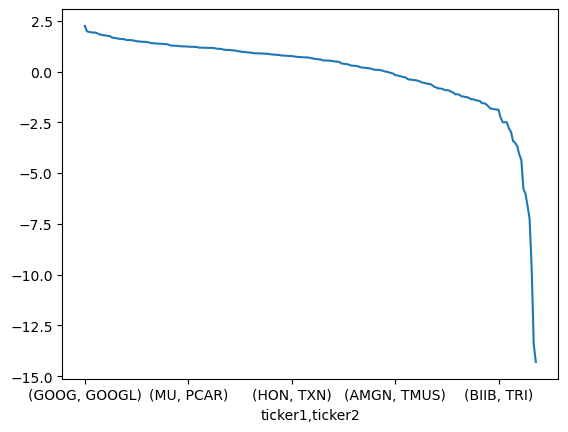

In [36]:
ranked['score'].plot()

In [37]:
ranked_positive = ranked[ranked["score"] > 0]

In [38]:
# robust_pairs = summary[summary['verdict']=='stationary'].index.to_list()
robust_pairs = ranked_positive.index

In [39]:
len(pairs_dual), len(robust_pairs)

(219, 146)

In [40]:
import random
(ticker1, ticker2) = robust_pairs[random.randint(0, len(robust_pairs)-1)]
# (ticker1, ticker2) = robust_pairs[0]
print('Pairs:', ticker1, ticker2)

Pairs: ADBE WDAY


In [41]:
import numpy as np, pandas as pd

# ---- 1) Half-life estimate for the spread (AR(1) approximation) ----
def estimate_halflife(spread: pd.Series, min_win: int = 30, max_win: int = 252) -> int:
    s = pd.Series(spread).dropna()
    if len(s) < min_win + 1:
        return min_win
    x = s.shift(1).dropna()
    y = s.dropna().loc[x.index]
    if len(x) < min_win:
        return min_win
    # OLS slope for AR(1): s_t = phi * s_{t-1} + eps
    phi = (x @ y) / (x @ x)
    if not (0 < phi < 1):
        return min_win
    hl = -np.log(2) / np.log(phi)
    win = int(np.clip(3 * hl, min_win, max_win))   # common heuristic
    return win

# ---- 2) Z-score builders (rolling / EWM / robust) ----
def zscore_from_spread(spread: pd.Series,
                       method: str = "rolling",
                       window: int | None = None,
                       halflife: float | None = None) -> pd.Series:
    s = pd.Series(spread).astype(float)
    if method == "ewm":
        if halflife is None:
            # default: derive from half-life of spread
            halflife = max(10.0, float(estimate_halflife(s)))
        mu = s.ewm(halflife=halflife, adjust=False).mean()
        sd = s.ewm(halflife=halflife, adjust=False).std(bias=False)
    elif method == "robust":
        if window is None:
            window = estimate_halflife(s)
        med = s.rolling(window, min_periods=window).median()
        mad = (s - med).abs().rolling(window, min_periods=window).median()
        sd = 1.4826 * mad                     # ≈ robust σ
        mu = med
    else:  # "rolling"
        if window is None:
            window = estimate_halflife(s)
        mu = s.rolling(window, min_periods=window).mean()
        sd = s.rolling(window, min_periods=window).std(ddof=0)
    z = (s - mu) / sd
    return z.replace([np.inf, -np.inf], np.nan)


def generate_pair_signals(
    df_pair: pd.DataFrame,
    *,
    z_method: str = "rolling",
    z_window: int | None = None,
    z_halflife: float | None = None,
    z_entry: float = 2.0,
    z_exit: float = 0.5,
    z_stop: float = 4.0,
    capital_per_pair: float = 10_000.0,
    max_hold_bars: int | None = None,
    cooldown_bars: int = 0,
    exec_lag: int = 1,              # execute next bar by default (no look-ahead)
) -> pd.DataFrame:
    """
    Returns columns: ['z','pos','n1','n2','entry','exit','stop'].
    'pos','n1','n2','entry','exit','stop' are aligned to the *execution* bar.
    """
    df = df_pair.copy()
    df["z"] = zscore_from_spread(df["resid"], method=z_method,
                                 window=z_window, halflife=z_halflife)

    n = len(df)
    pos_dec  = np.zeros(n, dtype=int)     # decisions at time t (pre-execution)
    n1_dec   = np.zeros(n, dtype=float)
    n2_dec   = np.zeros(n, dtype=float)
    ent_dec  = np.zeros(n, dtype=bool)
    exit_dec = np.zeros(n, dtype=bool)
    stop_dec = np.zeros(n, dtype=bool)

    pos = 0
    hold = 0
    cooldown = 0

    for t in range(n):
        z = df["z"].iloc[t]
        P1 = df["P1"].iloc[t]
        P2 = df["P2"].iloc[t]
        beta_t = df["beta"].iloc[t]

        # Not enough info: stay flat
        if (np.isnan(z) or np.isnan(P1) or np.isnan(P2) or np.isnan(beta_t) or
            P1 <= 0 or P2 <= 0):
            pos = 0; hold = 0
            pos_dec[t] = 0; n1_dec[t] = 0.0; n2_dec[t] = 0.0
            continue

        if cooldown > 0:
            cooldown -= 1
        can_enter = (cooldown == 0)

        # Decide using info up to and including t
        if pos == 0 and can_enter:
            if z <= -z_entry:
                pos = +1; hold = 1; ent_dec[t] = True
            elif z >= +z_entry:
                pos = -1; hold = 1; ent_dec[t] = True
        elif pos == +1:
            hold += 1
            if abs(z) <= z_exit:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif z <= -z_stop:
                pos = 0; stop_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif max_hold_bars and hold >= max_hold_bars:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
        elif pos == -1:
            hold += 1
            if abs(z) <= z_exit:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif z >= +z_stop:
                pos = 0; stop_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif max_hold_bars and hold >= max_hold_bars:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars

        pos_dec[t] = pos

        # Size targets with info at t
        if pos != 0:
            scale = capital_per_pair / (P1 + abs(beta_t) * P2)
            n1_dec[t] = pos * scale
            n2_dec[t] = -pos * scale * beta_t
        else:
            n1_dec[t] = 0.0
            n2_dec[t] = 0.0

    # --- Execution alignment ---
    if exec_lag < 0:
        raise ValueError("exec_lag must be >= 0")
    pos_exe  = pd.Series(pos_dec).shift(exec_lag, fill_value=0).astype(int).values
    n1_exe   = pd.Series(n1_dec).shift(exec_lag, fill_value=0.0).values
    n2_exe   = pd.Series(n2_dec).shift(exec_lag, fill_value=0.0).values
    entry_ex = pd.Series(ent_dec).shift(exec_lag, fill_value=False).astype(bool).values
    exit_ex  = pd.Series(exit_dec).shift(exec_lag, fill_value=False).astype(bool).values
    stop_ex  = pd.Series(stop_dec).shift(exec_lag, fill_value=False).astype(bool).values

    out = pd.DataFrame({
        "z": df["z"].values,         # contemporaneous z (not shifted)
        "pos": pos_exe,
        "n1": n1_exe,
        "n2": n2_exe,
        "entry": entry_ex,
        "exit": exit_ex,
        "stop": stop_ex,
    }, index=df.index)

    return out


In [42]:
# Build df_pair for ('AAPL','MSFT')
# df_kf = kf_res[('AAPL','MSFT')]  # has ['alpha','beta','y_hat','resid']
# prices = data.pivot_table(index=data.index, columns='ticker', values='close')
# df_pair = pd.DataFrame({
#     'P1': prices['AAPL'],
#     'P2': prices['MSFT'],
# }).join(df_kf[['beta','resid']])

df_kf = states_tr[(ticker1, ticker2)]
prices = df.pivot_table(index=df.index.get_level_values('datetime'), columns=df.index.get_level_values('ticker'), values='close')

In [43]:
df_pair = pd.DataFrame({
    'P1': prices[ticker1],
    'P2': prices[ticker2]
}).join(df_kf[['beta', 'resid']])

In [44]:
signals = generate_pair_signals(
    df_pair,
    z_method="robust",
    z_entry=2.0, z_exit=0.5, z_stop=4.0,
    capital_per_pair=10_000,
    max_hold_bars=None,            # set like 3*estimate_halflife(df_pair['resid'])
    cooldown_bars=0
)

# signals[['z','pos','n1','n2','entry','exit','stop']].tail()

In [45]:
signals

,z,pos,n1,n2,entry,exit,stop
datetime,,,,,,,
2015-01-02 05:00:00+00:00,NaN,0,0.0,0.0,False,False,False
2015-01-05 05:00:00+00:00,NaN,0,0.0,0.0,False,False,False
2015-01-06 05:00:00+00:00,NaN,0,0.0,0.0,False,False,False
2015-01-07 05:00:00+00:00,NaN,0,0.0,0.0,False,False,False
2015-01-08 05:00:00+00:00,NaN,0,0.0,0.0,False,False,False
...,...,...,...,...,...,...,...
2024-12-24 05:00:00+00:00,-0.265029,0,0.0,0.0,False,False,False
2024-12-26 05:00:00+00:00,0.202077,0,0.0,0.0,False,False,False
2024-12-27 05:00:00+00:00,-0.009295,0,0.0,0.0,False,False,False


### Plot of Trading Signals

In [46]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _spans_from_bool(mask: pd.Series):
    """Yield (start, end) timestamps where mask is True (contiguous runs)."""
    m = mask.astype(bool).astype(int)
    dm = m.diff().fillna(0)
    starts = list(mask.index[dm == 1])
    ends   = list(mask.index[dm == -1])
    # If we start in a True run, prepend the first index
    if m.iloc[0] == 1:
        starts = [mask.index[0]] + starts
    # If we end in a True run, append the last index
    if len(ends) < len(starts):
        ends = ends + [mask.index[-1]]
    return zip(starts, ends)

def plot_pair_legs_with_trades(
    df_pair: pd.DataFrame,
    signals: pd.DataFrame,
    *,
    label1: str = "P1", label2: str = "P2",
    normalize: bool = True, base_value: float = 100.0,
    shade_positions: bool = True,
    shade_color: str = "0.85", shade_alpha: float = 0.25,  # <<< new: robust shading
    size_scale: float = 0.002, min_marker: float = 20.0, max_marker: float = 220.0,
    buy_color: str = "tab:green", sell_color: str = "tab:red",
):
    # align data
    cols = ["P1","P2"]
    extra = [c for c in ["pos","n1","n2","entry","exit","stop"] if c in signals.columns]
    df = pd.concat([df_pair[cols], signals[extra]], axis=1).dropna(subset=["P1","P2"]).copy()

    # trades (Δshares)
    s = signals.loc[df.index].copy()
    df["trade1"] = s["n1"].diff().fillna(s["n1"]).where(lambda x: x.abs() > 1e-9, 0.0)
    df["trade2"] = s["n2"].diff().fillna(s["n2"]).where(lambda x: x.abs() > 1e-9, 0.0)

    # normalize for display
    if normalize:
        p1_0, p2_0 = df["P1"].iloc[0], df["P2"].iloc[0]
        df["P1_plot"] = df["P1"] / p1_0 * base_value
        df["P2_plot"] = df["P2"] / p2_0 * base_value
        ylab = f"Price (base={base_value:.0f})"
    else:
        df["P1_plot"] = df["P1"]; df["P2_plot"] = df["P2"]
        ylab = "Price"

    # marker sizing by notional
    df["notional1"] = (df["trade1"].abs() * df["P1"]).fillna(0.0)
    df["notional2"] = (df["trade2"].abs() * df["P2"]).fillna(0.0)

    buy1, sell1 = df.index[df["trade1"] > 0], df.index[df["trade1"] < 0]
    buy2, sell2 = df.index[df["trade2"] > 0], df.index[df["trade2"] < 0]
    s1 = np.clip(df.loc[buy1.union(sell1), "notional1"] * size_scale, min_marker, max_marker)
    s2 = np.clip(df.loc[buy2.union(sell2), "notional2"] * size_scale, min_marker, max_marker)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

    # --- robust shading: use axvspan on both axes ---
    if shade_positions and "pos" in df:
        for a in (ax1, ax2):
            for start, end in _spans_from_bool(df["pos"].ne(0)):
                a.axvspan(start, end, color=shade_color, alpha=shade_alpha, zorder=0)

    # --- Leg 1 ---
    ax1.plot(df.index, df["P1_plot"], linewidth=1.2, label=label1, zorder=2)
    ax1.scatter(buy1,  df.loc[buy1,  "P1_plot"], marker="^", s=s1.loc[buy1],
                label="Buy n1",  color=buy_color, zorder=3)
    ax1.scatter(sell1, df.loc[sell1, "P1_plot"], marker="v", s=s1.loc[sell1],
                label="Sell n1", color=sell_color, zorder=3)
    ax1.set_ylabel(ylab); ax1.grid(True, alpha=0.3); ax1.legend(loc="upper left")

    # --- Leg 2 ---
    ax2.plot(df.index, df["P2_plot"], linewidth=1.2, label=label2, linestyle="--", zorder=2)
    ax2.scatter(buy2,  df.loc[buy2,  "P2_plot"], marker="^", s=s2.loc[buy2],
                label="Buy n2",  color=buy_color, zorder=3)
    ax2.scatter(sell2, df.loc[sell2, "P2_plot"], marker="v", s=s2.loc[sell2],
                label="Sell n2", color=sell_color, zorder=3)
    ax2.set_ylabel(ylab); ax2.grid(True, alpha=0.3); ax2.legend(loc="upper left")

    ax2.set_title(f"Trades superimposed on each leg • {label1} (top), {label2} (bottom)")
    plt.tight_layout()
    return fig, (ax1, ax2)


(<Figure size 1300x800 with 2 Axes>,
 (<Axes: ylabel='Price (base=100)'>,
  <Axes: title={'center': 'Trades superimposed on each leg • ADBE (top), WDAY (bottom)'}, ylabel='Price (base=100)'>))

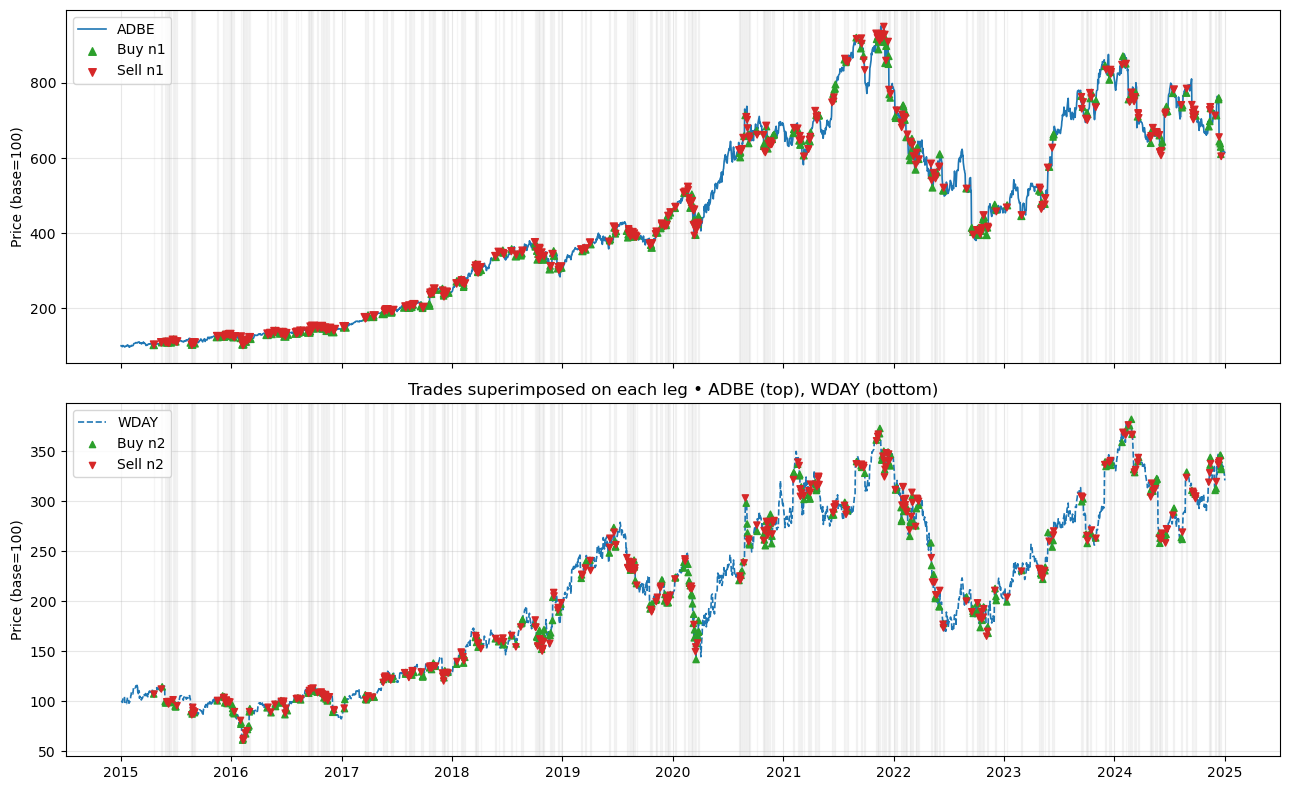

In [47]:
# df_pair: has P1,P2 columns (and optionally beta,y_hat)
# signals: from generate_pair_signals(...), has z,pos,n1,n2,entry,exit,stop

plot_pair_legs_with_trades(
    df_pair, signals,
    label1=ticker1, label2=ticker2,
    normalize=True, base_value=100,
    shade_positions=True,
    size_scale=0.004,   # tweak to taste based on your notional levels
    min_marker=20, max_marker=220
)


### Evaluate Performance of the Strategy

In [48]:
import numpy as np, pandas as pd

def evaluate_pair_signals(
    df_pair: pd.DataFrame,
    signals: pd.DataFrame,
    *,
    # cost model
    cost_bps: float = 0.0,            # commission+slippage, bps of traded notional (per leg)
    fee_per_share_1: float = 0.0,     # fixed fee per share for leg 1
    fee_per_share_2: float = 0.0,     # fixed fee per share for leg 2
    borrow_bps_per_year: float = 0.0, # short borrow (annual bps on short market value)
    days_per_year: int = 252,         # kept for backward-compat
    # return scaling
    capital_base: float | None = None,  # if None: percentile of in-position gross exposure
    capital_base_percentile: float = 0.5,  # 0.5 = median; set 0.6/0.7 to be more conservative
    min_capital_base: float = 1.0,
    # generalization & trade parsing
    bars_per_year: int | None = None,      # if None, defaults to days_per_year
    treat_reversals_as_round_trips: bool = True
):
    """
    Evaluate a single pair's executed signals (next-bar safe).
    Assumes `signals` has executed columns: ['pos','n1','n2'] (and optionally 'z','entry','exit','stop']).

    Returns:
        daily  : DataFrame with pnl/returns/exposure/turnover/drawdowns
        trades : DataFrame of round-trip trades (reversals optional)
        summary: dict of key metrics (backward-compatible keys preserved)
    """
    # --- align & sanity -------------------------------------------------------
    cols = ["P1", "P2"]
    if not set(cols).issubset(df_pair.columns):
        raise KeyError(f"df_pair must contain {cols}")

    df = pd.concat([df_pair[cols], signals], axis=1).sort_index().copy()

    # simple price sanity (optional): drop rows with non-finite or non-positive prices
    bad = ~np.isfinite(df["P1"]) | ~np.isfinite(df["P2"]) | (df["P1"] <= 0) | (df["P2"] <= 0)
    if bad.any():
        df = df.loc[~bad]

    n = len(df)
    if n == 0:
        empty = pd.DataFrame(columns=[
            "pnl_gross","cost","pnl_net","ret_gross","ret_net","equity","portfolio",
            "gross_exposure","net_exposure","turnover","in_pos","drawdown","drawdown_pct"
        ])
        return empty, pd.DataFrame(), {
            "start": None, "end": None, "bars": 0, "capital_base": float("nan"),
            "gross_pnl": 0.0, "net_pnl": 0.0, "ann_return": float("nan"),
            "sharpe": float("nan"), "max_drawdown": 0.0, "max_drawdown_pct": 0.0,
            "avg_gross_exposure": 0.0, "avg_exposure_utilization": 0.0,
            "turnover_annualized": 0.0, "n_trades": 0, "hit_rate": float("nan"),
            "avg_win": float("nan"), "avg_loss": float("nan"),
            "profit_factor": float("inf"), "avg_hold_bars": float("nan"), "med_hold_bars": float("nan"),
            # extras
            "ann_vol": float("nan"), "sortino": float("nan"),
            "avg_daily_dollars_traded": 0.0
        }

    # executed holdings
    n1 = df["n1"].astype(float).fillna(0.0)
    n2 = df["n2"].astype(float).fillna(0.0)
    pos = (np.sign(n1) != 0) | (np.sign(n2) != 0)

    # convenience: side of spread (+1 long-spread, -1 short-spread, 0 flat)
    side = pd.Series(0, index=df.index, dtype=float)
    side.loc[n1 != 0] = np.sign(n1.loc[n1 != 0])
    side.loc[(side == 0) & (n2 != 0)] = np.sign(n2.loc[(side == 0) & (n2 != 0)])

    # --- price changes (close-to-close PnL with executed holdings) ------------
    dP1 = df["P1"].astype(float).diff().fillna(0.0)
    dP2 = df["P2"].astype(float).diff().fillna(0.0)
    pnl_gross = n1 * dP1 + n2 * dP2

    # --- trades and costs -----------------------------------------------------
    dn1 = n1.diff().fillna(n1)   # Δshares executed on this bar
    dn2 = n2.diff().fillna(n2)
    traded_notional = (dn1.abs() * df["P1"]) + (dn2.abs() * df["P2"])

    cost_comm_slip  = (cost_bps / 1e4) * traded_notional
    cost_per_share  = fee_per_share_1 * dn1.abs() + fee_per_share_2 * dn2.abs()

    short_notional = (np.where(n1 < 0, -n1 * df["P1"], 0.0)
                    + np.where(n2 < 0, -n2 * df["P2"], 0.0))
    # accrue borrow daily on short market value
    cost_borrow = short_notional * (borrow_bps_per_year / 1e4) / float(days_per_year)

    cost_total = cost_comm_slip + cost_per_share + cost_borrow
    pnl_net = pnl_gross - cost_total

    # --- exposures & returns --------------------------------------------------
    gross_exposure = n1.abs() * df["P1"] + n2.abs() * df["P2"]
    net_exposure   = n1 * df["P1"] + n2 * df["P2"]

    if capital_base is None:
        inpos_expo = gross_exposure.where(pos)
        if inpos_expo.notna().any():
            cb = float(np.nanquantile(inpos_expo, capital_base_percentile))
        else:
            cb = float(np.nanquantile(gross_exposure, capital_base_percentile))
        if not np.isfinite(cb) or cb <= 0:
            cb = float(min_capital_base)
        capital_base = cb

    # returns scaled to fixed capital base
    ret_gross = pnl_gross / capital_base
    ret_net   = pnl_net   / capital_base
    equity    = pnl_net.cumsum()

    # portfolio value & drawdowns (on portfolio, not equity)
    portfolio = capital_base + equity
    peak_port = portfolio.cummax()
    # Numerically stable drawdown% with safe first row
    with np.errstate(divide="ignore", invalid="ignore"):
        dd_pct = (portfolio / peak_port) - 1.0
    dd_pct = dd_pct.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    dd = portfolio - peak_port

    # --- turnover -------------------------------------------------------------
    daily_turnover = traded_notional / capital_base

    daily = pd.DataFrame({
        "pnl_gross": pnl_gross,
        "cost": cost_total,
        "pnl_net": pnl_net,
        "ret_gross": ret_gross,
        "ret_net": ret_net,
        "equity": equity,
        "portfolio": portfolio,
        "gross_exposure": gross_exposure,
        "net_exposure": net_exposure,
        "turnover": daily_turnover,
        "in_pos": pos.astype(int),
        "drawdown": dd,
        "drawdown_pct": dd_pct,
    })

    # --- per-trade breakdown (round trips) -----------------------------------
    # default: entries on pos rising-edge; exits on pos falling-edge
    entries = pd.Index(daily.index[(pos) & (~pos.shift(1, fill_value=False))])
    exits   = pd.Index(daily.index[(~pos) & (pos.shift(1, fill_value=False))])

    # Optionally treat reversals as exit+entry on the same bar
    if treat_reversals_as_round_trips:
        side_change = (side != side.shift(1)).fillna(False)
        reversals = daily.index[pos & pos.shift(1, fill_value=False) & side_change]
        entries = entries.union(reversals).sort_values()
        exits   = exits.union(reversals).sort_values()

    trade_rows = []
    for start in entries:
        after = exits[exits >= start]  # include same-bar for reversal
        if len(after) == 0:
            break
        end = after[0]

        # slice the interval where position was held; exclude the bar when flat after exit
        sl = daily.loc[start:end]
        # if this is a normal flat exit, last bar is flat; for reversals, it’s still in-pos.
        if (end in exits) and (end not in entries) and (sl["in_pos"].iloc[-1] == 0):
            sl = sl.iloc[:-1]

        if sl.empty:
            continue

        sgn = int(np.sign(n1.loc[start]) or np.sign(n2.loc[start]))  # +1 long-spread, -1 short-spread
        pnl_g = float(sl["pnl_gross"].sum())
        cst   = float(sl["cost"].sum())
        pnl_n = float(sl["pnl_net"].sum())
        ret   = float(sl["ret_net"].sum())
        hold  = int(sl.shape[0])
        z_e   = float(df["z"].loc[start]) if "z" in df.columns and pd.notna(df["z"].loc[start]) else np.nan
        # decision z the day before the exit execution (next-bar safe)
        z_prev_exit = float(df["z"].shift(1).loc[end]) if "z" in df.columns and end in df.index else np.nan

        # peak adverse excursion (on portfolio) during the trade
        trade_port = sl["portfolio"]
        pae = float((trade_port - trade_port.cummax()).min())  # most negative drawdown $ during trade

        trade_rows.append({
            "entry": start, "exit": end, "side": sgn,
            "bars": hold, "pnl_gross": pnl_g, "cost": cst, "pnl_net": pnl_n, "ret_on_cap": ret,
            "z_at_entry": z_e, "z_prev_exit": z_prev_exit,
            "pae": pae,
            "turnover": float(sl["turnover"].sum())
        })

    trades = pd.DataFrame(trade_rows)
    if not trades.empty:
        wins = trades["pnl_net"] > 0
        profit_factor = (trades.loc[wins, "pnl_net"].sum() /
                         -trades.loc[~wins, "pnl_net"].sum()) if (~wins).any() else np.inf
        avg_hold = float(trades["bars"].mean())
        med_hold = float(trades["bars"].median())
        hitrate  = float(wins.mean())
        avg_win  = float(trades.loc[wins, "pnl_net"].mean()) if wins.any() else 0.0
        avg_loss = float(trades.loc[~wins, "pnl_net"].mean()) if (~wins).any() else 0.0
    else:
        profit_factor = np.inf; avg_hold = med_hold = hitrate = avg_win = avg_loss = np.nan

    # --- summary metrics ------------------------------------------------------
    periods_per_year = int(bars_per_year or days_per_year)
    n = daily.shape[0]
    ret_mean = daily["ret_net"].mean()
    ret_std  = daily["ret_net"].std(ddof=0)
    sharpe   = (ret_mean / ret_std) * np.sqrt(periods_per_year) if ret_std > 0 else np.nan

    # geometric annualized return on fixed-capital series
    gross_chain = (1.0 + daily["ret_gross"].fillna(0.0)).prod()
    net_chain   = (1.0 + daily["ret_net"].fillna(0.0)).prod()
    ann_ret     = (net_chain ** (periods_per_year / max(n, 1))) - 1.0

    # extras: annualized vol & Sortino (using 0 threshold)
    ann_vol  = (ret_std * np.sqrt(periods_per_year)) if ret_std > 0 else np.nan
    downside = daily["ret_net"].clip(upper=0.0)
    dstd = downside.std(ddof=0)
    sortino = (ret_mean / dstd) * np.sqrt(periods_per_year) if dstd > 0 else np.nan

    ann_turnover = daily["turnover"].sum() * (periods_per_year / max(n, 1))
    mdd = float(-daily["drawdown"].min())
    mdd_pct = float(-daily["drawdown_pct"].min())
    exposure_util = (daily.loc[pos, "gross_exposure"].mean() / capital_base) if pos.any() else 0.0

    summary = {
        "start": daily.index[0] if n else None,
        "end":   daily.index[-1] if n else None,
        "bars": n,
        "capital_base": float(capital_base),
        "gross_pnl": float(daily["pnl_gross"].sum()),
        "net_pnl": float(daily["pnl_net"].sum()),
        "ann_return": float(ann_ret),
        "sharpe": float(sharpe),
        "max_drawdown": mdd,
        "max_drawdown_pct": mdd_pct,
        "avg_gross_exposure": float(daily["gross_exposure"].mean()),
        "avg_exposure_utilization": float(exposure_util),
        "turnover_annualized": float(ann_turnover),
        "n_trades": int(len(trades)),
        "hit_rate": float(hitrate) if not np.isnan(hitrate) else np.nan,
        "avg_win": float(avg_win) if not np.isnan(avg_win) else np.nan,
        "avg_loss": float(avg_loss) if not np.isnan(avg_loss) else np.nan,
        "profit_factor": float(profit_factor) if np.isfinite(profit_factor) else np.inf,
        "avg_hold_bars": float(avg_hold) if not np.isnan(avg_hold) else np.nan,
        "med_hold_bars": float(med_hold) if not np.isnan(med_hold) else np.nan,
        # extras (non-breaking)
        "ann_vol": float(ann_vol) if not np.isnan(ann_vol) else np.nan,
        "sortino": float(sortino) if not np.isnan(sortino) else np.nan,
        "gross_return_chain": float(gross_chain),
        "net_return_chain": float(net_chain),
        "avg_daily_dollars_traded": float(traded_notional.mean()) if n else 0.0,
    }

    return daily, trades, summary


### Evaluate Performance on the training data

In [49]:
# df_pair has P1,P2; signals are your executed outputs (with next-bar logic)
daily, trades, summary = evaluate_pair_signals(
    df_pair, signals,
    cost_bps=1, fee_per_share_1=0.0, fee_per_share_2=0.0,
    borrow_bps_per_year=50,
    days_per_year=252,          # borrow accrual basis
    bars_per_year=252       # 390*252 for 1-min RTH scaling
)

print(pd.Series(summary))
# daily[['pnl_net','equity','drawdown_pct']].tail()
# trades.head()


start                       2015-01-02 05:00:00+00:00
end                         2024-12-31 05:00:00+00:00
bars                                             2516
capital_base                             10009.453244
gross_pnl                                 1536.428026
net_pnl                                    1106.30323
ann_return                                   0.006232
sharpe                                       0.112578
max_drawdown                              2003.034866
max_drawdown_pct                             0.185265
avg_gross_exposure                        2035.297621
avg_exposure_utilization                     0.999213
turnover_annualized                         38.452468
n_trades                                          189
hit_rate                                     0.560847
avg_win                                    112.771329
avg_loss                                  -128.415198
profit_factor                                1.121528
avg_hold_bars               

### Evaluate Trained Strategy on (Fressh, Unseen) Test Data

In [50]:
start_test="2025-01-02"
end_test="2025-08-15"

In [51]:
"""
df_test, failed = download_history_openbb([ticker1, ticker2], start_test, end_test, return_failed=True)

print(df_test.head())
if failed:
    print("No data for:", failed)
"""

'\ndf_test, failed = download_history_openbb([ticker1, ticker2], start_test, end_test, return_failed=True)\n\nprint(df_test.head())\nif failed:\n    print("No data for:", failed)\n'

In [52]:
df_test = load_polygonio_lake(
    [ticker1, ticker2],
    start_test,
    end_test,
    path_polygonio_data,
    columns=["datetime","ticker","open","high","low","close","volume"],
    to_timezone="UTC",
    set_index=True, index_multi=True,
    workers=64,
    debug=False
)

Loading Parquet: 100%|██████████| 16/16 [00:00<00:00, 386.73file/s]


In [53]:
df_test.head()

open        high         low  \
ticker datetime                                                        
ADBE   2025-01-02 05:00:00+00:00  447.760010  450.119995  440.559998   
       2025-01-03 05:00:00+00:00  429.445007  433.298187  425.320007   
       2025-01-06 05:00:00+00:00  431.880005  436.408203  427.790009   
       2025-01-07 05:00:00+00:00  431.369995  435.179993  420.510010   
       2025-01-08 05:00:00+00:00  417.339996  422.660004  415.510010   

                                       close   volume  
ticker datetime                                        
ADBE   2025-01-02 05:00:00+00:00  441.000000  2507887  
       2025-01-03 05:00:00+00:00  430.570007  5619372  
       2025-01-06 05:00:00+00:00  431.179993  3994400  
       2025-01-07 05:00:00+00:00  422.630005  4181405  
       2025-01-08 05:00:00+00:00  419.579987  3508786

In [54]:
import numpy as np
import pandas as pd
from typing import Optional, Dict, Tuple, Any
from pykalman import KalmanFilter

def _align_two(series1: pd.Series, series2: pd.Series, name1="P1", name2="P2") -> pd.DataFrame:
    if not isinstance(series1.index, pd.DatetimeIndex):
        series1 = series1.copy(); series1.index = pd.to_datetime(series1.index, errors="coerce")
    if not isinstance(series2.index, pd.DatetimeIndex):
        series2 = series2.copy(); series2.index = pd.to_datetime(series2.index, errors="coerce")
    series1 = series1.sort_index()
    series2 = series2.sort_index()
    df = pd.concat([series1.rename(name1), series2.rename(name2)], axis=1, join="inner").dropna()
    return df.astype(np.float64)

def _coerce_last_state(
    last_state: Any,
    init_cov: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Accepts:
      - dict with keys 'mean' & 'cov' (or 'last_state_mean', 'last_state_cov')
      - tuple/list of (mean, cov)
      - np.ndarray of shape (2,) for mean (cov = init_cov*I)
      - np.ndarray of shape (2,2) for cov (mean = zeros)
      - None  -> (zeros, init_cov*I)
    Returns (mean(2,), cov(2,2)) as float64.
    """
    I = np.eye(2, dtype=np.float64)
    if last_state is None:
        return np.zeros(2, dtype=np.float64), I * float(init_cov)

    # dict
    if isinstance(last_state, dict):
        mean = last_state.get("mean", last_state.get("last_state_mean", None))
        cov  = last_state.get("cov",  last_state.get("last_state_cov",  None))
        if mean is None and cov is None:
            raise ValueError("last_state dict must contain 'mean' and/or 'cov'.")
        if mean is None:
            mean = np.zeros(2, dtype=np.float64)
        if cov is None:
            cov = I * float(init_cov)
        return np.asarray(mean, dtype=np.float64).reshape(2,), np.asarray(cov, dtype=np.float64).reshape(2,2)

    # tuple/list
    if isinstance(last_state, (tuple, list)):
        if len(last_state) != 2:
            raise ValueError("last_state tuple/list must be (mean, cov).")
        mean, cov = last_state
        if mean is None:
            mean = np.zeros(2, dtype=np.float64)
        if cov is None:
            cov = I * float(init_cov)
        return np.asarray(mean, dtype=np.float64).reshape(2,), np.asarray(cov, dtype=np.float64).reshape(2,2)

    # ndarray only
    arr = np.asarray(last_state)
    if arr.shape == (2,):
        return arr.astype(np.float64), I * float(init_cov)
    if arr.shape == (2, 2):
        return np.zeros(2, dtype=np.float64), arr.astype(np.float64)

    raise TypeError("Unsupported last_state type/shape.")

def filter_kf_on_new(
    P1_new: pd.Series,
    P2_new: pd.Series,
    *,
    frozen: Dict[str, np.ndarray],          # {"F":2x2, "Q":2x2, "R":1x1}
    last_state: Optional[Any] = None,       # dict | (mean,cov) | ndarray | None
    init_cov: float = 1e6,
    mode: str = "filter",                    # or "smooth"
) -> Tuple[pd.DataFrame, Dict[str, np.ndarray]]:
    # 1) Align
    df = _align_two(P1_new, P2_new, "P1", "P2")
    if len(df) < 5:
        raise ValueError("Not enough overlapping observations after alignment.")

    # 2) Inputs
    y = df["P1"].values.reshape(-1, 1)
    x = df["P2"].values
    n = len(df)

    H = np.zeros((n, 1, 2), dtype=np.float64)
    H[:, 0, 0] = x
    H[:, 0, 1] = 1.0

    F = np.asarray(frozen["F"], dtype=np.float64)
    Q = np.asarray(frozen["Q"], dtype=np.float64)
    R = np.asarray(frozen["R"], dtype=np.float64)

    init_mean, init_covm = _coerce_last_state(last_state, init_cov)

    # 3) Run KF
    kf = KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        initial_state_mean=init_mean,
        initial_state_covariance=init_covm,
        transition_covariance=Q,
        observation_covariance=R,
    )

    if mode == "smooth":
        state_means, state_covs = kf.smooth(y)
        f_means, f_covs = kf.filter(y)  # to export filtered terminal state
        last_mean, last_cov = f_means[-1].copy(), f_covs[-1].copy()
    else:
        state_means, state_covs = kf.filter(y)
        last_mean, last_cov = state_means[-1].copy(), state_covs[-1].copy()

    beta_t  = state_means[:, 0]
    alpha_t = state_means[:, 1]
    y_hat   = alpha_t + beta_t * x
    resid   = df["P1"].values - y_hat

    out = pd.DataFrame(
        {"alpha": alpha_t, "beta": beta_t, "y_hat": y_hat, "resid": resid},
        index=df.index,
    )

    # Standardize the returned state format
    last_state_out = {"mean": last_mean, "cov": last_cov}
    return out, last_state_out


In [55]:
# pick the pair you trained
pair = (ticker1, ticker2)

# freeze hyperparameters learned on TRAIN
frozen = {
    "F": params_tr[pair]["F"],
    "Q": params_tr[pair]["Q"],
    "R": params_tr[pair]["R"],
}

# start the new run from the last *filtered* TRAIN state (or use None for diffuse)
last_state = (params_tr[pair]["last_state_mean"], params_tr[pair]["last_state_cov"])

# make sure P1_new, P2_new are aligned and share the same DateTimeIndex
P1_new = df_test.loc[(ticker1,), 'close']
P2_new = df_test.loc[(ticker2,), 'close']

df_new_states, last_state = filter_kf_on_new(
    P1_new, P2_new,
    frozen=frozen,
    last_state=last_state,   # or None if this is a disjoint start
    init_cov=1e6,
    mode="filter",
)

# df_new_states has ['alpha','beta','y_hat','resid'] for the new period


In [56]:
df_new_states.head()

,alpha,beta,y_hat,resid
datetime,,,,
2025-01-02 05:00:00+00:00,112.536216,1.294615,438.572051,2.427949
2025-01-03 05:00:00+00:00,112.535420,1.260607,431.267360,-0.697353
2025-01-06 05:00:00+00:00,112.535421,1.254303,431.304046,-0.124053
2025-01-07 05:00:00+00:00,112.535007,1.242886,422.858832,-0.228827
2025-01-08 05:00:00+00:00,112.535827,1.208227,420.259194,-0.679208


In [57]:
df_pair_test = pd.DataFrame({
    'P1': P1_new,
    'P2': P2_new
}).join(df_new_states[['beta', 'resid']])

In [58]:
signals_test = generate_pair_signals(
    df_pair_test,
    z_method="robust",
    z_entry=2.0, z_exit=0.5, z_stop=4.0,
    capital_per_pair=10_000,
    max_hold_bars=None,            # set like 3*estimate_halflife(df_pair['resid'])
    cooldown_bars=0
)

(<Figure size 1300x800 with 2 Axes>,
 (<Axes: ylabel='Price (base=100)'>,
  <Axes: title={'center': 'Trades superimposed on each leg • ADBE (top), WDAY (bottom)'}, ylabel='Price (base=100)'>))

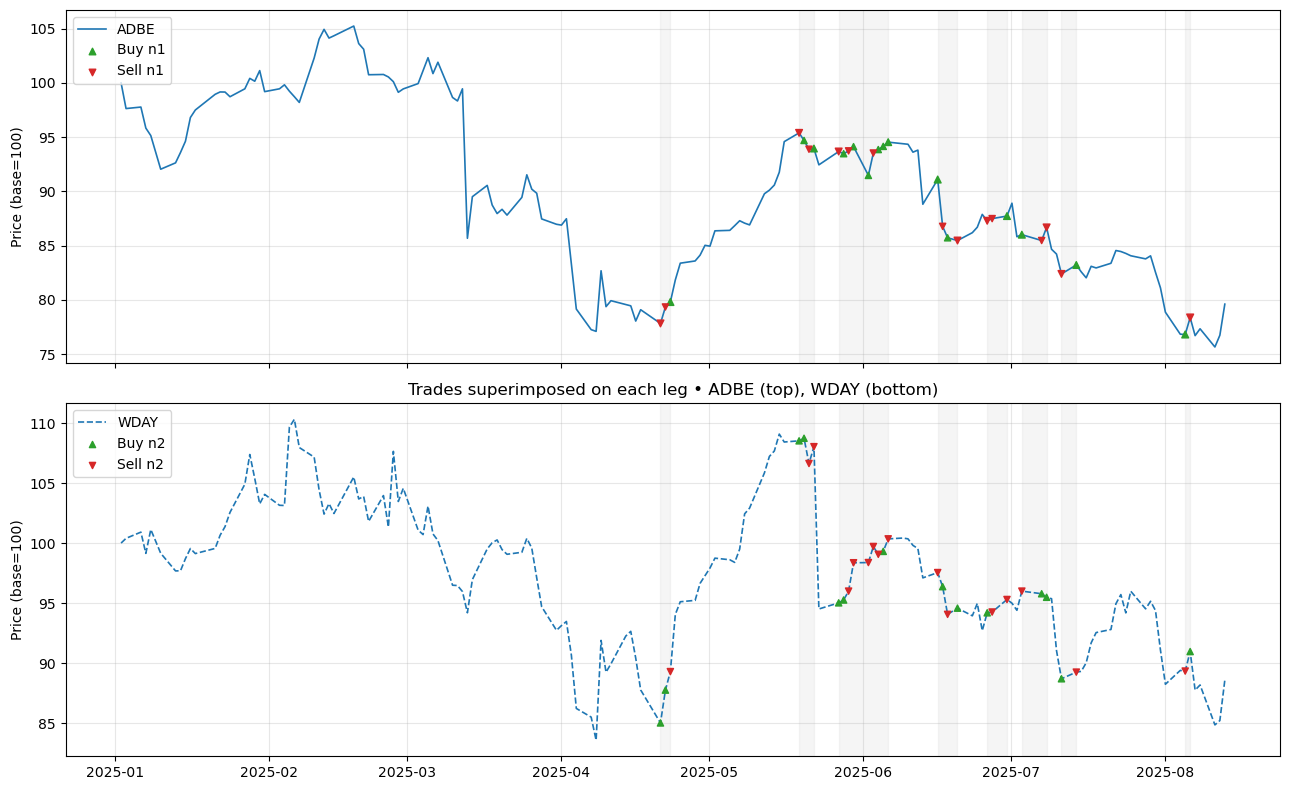

In [59]:
# df_pair: has P1,P2 columns (and optionally beta,y_hat)
# signals: from generate_pair_signals(...), has z,pos,n1,n2,entry,exit,stop

plot_pair_legs_with_trades(
    df_pair_test, signals_test,
    label1=ticker1, label2=ticker2,
    normalize=True, base_value=100,
    shade_positions=True,
    size_scale=0.004,   # tweak to taste based on your notional levels
    min_marker=20, max_marker=220
)


In [61]:
# df_pair has P1,P2; signals are your executed outputs (with next-bar logic)
daily, trades, summary_test = evaluate_pair_signals(
    df_pair, signals,
    cost_bps=1, fee_per_share_1=0.0, fee_per_share_2=0.0,
    borrow_bps_per_year=50,
    days_per_year=252,          # borrow accrual basis
    bars_per_year=252       # 390*252 for 1-min RTH scaling
)

print(pd.Series(summary_test))
# daily[['pnl_net','equity','drawdown_pct']].tail()
# trades.head()

start                       2015-01-02 05:00:00+00:00
end                         2024-12-31 05:00:00+00:00
bars                                             2516
capital_base                             10009.453244
gross_pnl                                 1536.428026
net_pnl                                    1106.30323
ann_return                                   0.006232
sharpe                                       0.112578
max_drawdown                              2003.034866
max_drawdown_pct                             0.185265
avg_gross_exposure                        2035.297621
avg_exposure_utilization                     0.999213
turnover_annualized                         38.452468
n_trades                                          189
hit_rate                                     0.560847
avg_win                                    112.771329
avg_loss                                  -128.415198
profit_factor                                1.121528
avg_hold_bars               